In [1]:
#导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
%matplotlib inline

# 注意下方单元格的文件路径，自己运行时需要修改（可以点击文件属性查找路径）

In [2]:
#设置LSTM的时间窗等参数
window=5
lstm_units = 16
dropout = 0.01
epoch=20
#读取数据
file_path = "..//风电场数据.xlsx"

df_data0 =  pd.read_excel(file_path,sheet_name='实际功率')

df_data2 =  pd.read_excel(file_path,sheet_name='气象数据')


In [3]:
print(df_data0.isnull().sum())  #统计每列有几个缺失值
missing_col = df_data0.columns[df_data0.isnull().any()].tolist() #找出存在缺失值的列
print("\n\n")

print(df_data2.isnull().sum())  #统计每列有几个缺失值
missing_col = df_data2.columns[df_data2.isnull().any()].tolist() #找出存在缺失值的列
print("\n\n")

import numpy as np
#统计每个变量的缺失值占比
def CountNA(data):
    cols = data.columns.tolist()    #cols为data的所有列名
    n_df = data.shape[0]    #n_df为数据的行数
    for col in cols:
        missing = np.count_nonzero(data[col].isnull().values)  #col列中存在的缺失值个数
        mis_perc = float(missing) / n_df * 100
        print("{col}的缺失比例是{miss}%".format(col=col,miss=mis_perc))
#构造处理缺失值函数
def data_null(data, a):
    data[a] = data[a].fillna(method='pad')

时间      0
场站编码    0
实际功率    0
dtype: int64



场站编码      0
时间        0
10米风向     0
110米风向    0
30米风向     0
50米风向     0
70米风向     0
80米风向     0
90米风向     0
湿度        0
辐照度       0
10米风速     0
110米风速    0
30米风速     0
50米风速     0
70米风速     0
80米风速     0
90米风速     0
气压        0
10米温度     0
110米温度    0
温度        0
30米温度     0
50米温度     0
70米温度     0
80米温度     0
90米温度     0
dtype: int64





In [4]:
#读取日期数据
from datetime import datetime
#构造"data0"年月日
df_data0.loc[:, '时间'] = pd.to_datetime(df_data0['时间'],format='%Y-%m-%d %H:%M:%S.%f')

# 几年，"年"为构造的新列
df_data0.loc[:, '年'] = df_data0['时间'].apply(lambda x: x.year) 

# 几年，"月"为构造的新列
df_data0.loc[:, '月'] = df_data0['时间'].apply(lambda x: x.month)

# 几号，"日"为构造的新列
df_data0.loc[:, '日'] = df_data0['时间'].apply(lambda x: x.day)

# 几时，"时"为构造的新列
df_data0.loc[:, '时'] = df_data0['时间'].apply(lambda x: x.hour)

# 几分，"分"为构造的新列
df_data0.loc[:, '分'] = df_data0['时间'].apply(lambda x: x.minute)

#删除原来日期列
df_data0 = df_data0.drop(['时间','场站编码'], axis=1)

In [5]:
#构造"data2"年月日
df_data2.loc[:, '时间'] = pd.to_datetime(df_data2['时间'],format='%Y-%m-%d %H:%M:%S.%f')

# 几年，"年"为构造的新列
df_data2.loc[:, '年'] = df_data2['时间'].apply(lambda x: x.year) 

# 几年，"月"为构造的新列
df_data2.loc[:, '月'] = df_data2['时间'].apply(lambda x: x.month)

# 几号，"日"为构造的新列
df_data2.loc[:, '日'] = df_data2['时间'].apply(lambda x: x.day)

# 几时，"时"为构造的新列
df_data2.loc[:, '时'] = df_data2['时间'].apply(lambda x: x.hour)

# 几分，"分"为构造的新列
df_data2.loc[:, '分'] = df_data2['时间'].apply(lambda x: x.minute)

# 删除原来日期列
df_data2 = df_data2.drop(['场站编码'], axis=1)

In [6]:
#删除重复三次以上的值
#删除为负值的数字
#设置patience，如果patience大于等于3则记录该点index
patience = 3
index0 = []
flag = 0
index = []

for i in range(len(df_data0)-1):
    if df_data0["实际功率"][i+1] - df_data0["实际功率"][i] != 0:
        flag = 0
    elif df_data0["实际功率"][i+1] - df_data0["实际功率"][i] == 0 :
        flag +=1
        if flag >=3:
            index0 = np.append(index0, i)
    elif df_data0["实际功率"][i] < 0:
        index0 = np.append(index0, i)

index0 = index0.astype(int)           
for i in range(len(index0)):
    if i >0 :
        if index0[i]-index0[i-1] == 1 :
            index = np.append(index, index0[i])  
        elif index0[i]-index0[i-1] > 1:
            index = np.append(index, index0[i]-2)
            index = np.append(index, index0[i]-1)
            index = np.append(index, index0[i])            
    else:
        if index0[i] > 0:
            index = np.append(index, index0[i]-2)
            index = np.append(index, index0[i]-1)
            index = np.append(index, index0[i])  
index = index.astype(int)
df_data0.drop(index,inplace=True)
df_data0 = df_data0.reset_index(drop=True)

In [7]:
#找出日期相同数据的索引函数
#利用flag减少计算量
def link_sheet(data1, data2):
    same1 = []
    same2 = []
    flag = 0
    for i in range(len(data1) - 1):
        for j in range(flag,len(data2) - 1):
            if data1["年"][i] < data2["年"][j]:
                break
            elif data1["年"][i] > data2["年"][j]:
                continue
            elif data1["年"][i] == data2["年"][j]:
                if data1["月"][i] < data2["月"][j]:
                    break
                elif data1["月"][i] > data2["月"][j]:
                    continue
                elif data1["月"][i] == data2["月"][j]:
                        if data1["日"][i] < data2["日"][j]:
                            break
                        elif data1["日"][i] > data2["日"][j]:
                            continue
                        elif data1["日"][i] == data2["日"][j]:
                            if data1["时"][i] < data2["时"][j]:
                                break
                            elif data1["时"][i] > data2["时"][j]:
                                continue
                            elif data1["时"][i] == data2["时"][j]:
                                if data1["分"][i] == data2["分"][j]:
                                    same1 = np.append(same1,i)
                                    same2 = np.append(same2,j)
                                    flag = j
    same1 = same1.astype(int)
    same2 = same2.astype(int)
    return same1, same2

In [8]:
data_same02, data_same20 = link_sheet(df_data0, df_data2)

In [9]:
#挑出日期相同的行
data_02 = df_data0.loc[data_same02]
data_02 = data_02.reset_index(drop=True)
data_20 = df_data2.loc[data_same20]
data_20 = data_20.reset_index(drop=True)

In [10]:
data_20.loc[:, '实际功率'] = data_02['实际功率']
df_data = data_20

#保存数据用
import copy
df_data_save0 = copy.deepcopy(data_20)

In [11]:
df_data = df_data.drop(['年',"月",'日','时',"分"], axis=1)

In [12]:
df1=df_data
df1=df1.iloc[:,2:]
df1.tail()

,110米风向,30米风向,50米风向,70米风向,80米风向,90米风向,湿度,辐照度,10米风速,110米风速,...,气压,10米温度,110米温度,温度,30米温度,50米温度,70米温度,80米温度,90米温度,实际功率
48440,21.7355,19.3753,20.2562,20.9585,21.2371,21.5520,87.5865,0.0,4.4132,7.1707,...,1019.70,0.4302,-0.0259,0.7108,0.2385,0.1495,0.0907,0.0674,0.0557,47.09
48441,21.3508,19.2296,20.0595,20.7696,21.0515,21.2896,88.0403,0.0,4.3781,7.1113,...,1019.69,0.3753,-0.0854,0.6592,0.1813,0.0913,0.0318,0.0082,-0.0035,42.32
48442,20.9712,19.1263,19.8895,20.5968,20.8775,21.0367,88.4620,0.0,4.3460,7.0543,...,1019.68,0.3215,-0.1420,0.6077,0.1260,0.0354,-0.0246,-0.0484,-0.0601,42.17
48443,20.6212,19.1040,19.7728,20.4558,20.7269,20.8101,88.8429,0.0,4.3168,6.9997,...,1019.66,0.2688,-0.1964,0.5564,0.0724,-0.0187,-0.0790,-0.1029,-0.1146,36.57
48444,20.3085,19.0605,19.6589,20.3285,20.5941,20.6098,89.1733,0.0,4.2878,6.9456,...,1019.63,0.2167,-0.2491,0.5049,0.0197,-0.0715,-0.1319,-0.1559,-0.1676,34.57


In [13]:
#进行数据归一化
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
df0=min_max_scaler.fit_transform(df1)
df = pd.DataFrame(df0, columns=df1.columns)
input_size=len(df.iloc[1,:])

In [14]:
#构建lstm输入
stock=df
seq_len=window
amount_of_features = len(stock.columns)#有几列
data = stock#pd.DataFrame(stock) 表格转化为矩阵
sequence_length = seq_len + 1#序列长度
result = []
for index in range(len(data) - sequence_length):#循环数据长度-sequence_length次
    result.append(data[index: index + sequence_length])#第i行到i+sequence_length
result = np.array(result)#得到样本，样本形式为6天*3特征
row = round(0.8 * result.shape[0])#划分训练集测试集
train = result[:int(row), :]
x_train = train[:, :-1]
y_train = train[:, -1][:,-1]
x_test = result[int(row):, :-1]
y_test = result[int(row):, -1][:,-1]
#reshape成 6天*3特征
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(38751, 5, 25) (38751,) (9688, 5, 25) (9688,)


In [15]:
#注意力机制代码
inputs=Input(shape=(window, input_size))
model=Conv1D(filters = lstm_units, kernel_size = 1, activation = 'sigmoid')(inputs)#卷积层
model=MaxPooling1D(pool_size = window)(model)#池化层
model=Dropout(dropout)(model)#droupout层
model=Bidirectional(LSTM(lstm_units, activation='tanh'), name='bilstm')(model)#双向LSTM层
attention=Dense(lstm_units*2, activation='sigmoid', name='attention_vec')(model)#求解Attention权重
model=Multiply()([model, attention])#attention与LSTM对应数值相乘
outputs = Dense(1, activation='tanh')(model)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mse',optimizer='adam')
model.summary()#展示模型结构

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 25)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 5, 16)        416         ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 1, 16)        0           ['conv1d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 1, 16)        0           ['max_pooling1d[0][0]']          
                                                                                              

In [16]:
history=model.fit(X_train, y_train, epochs = epoch, batch_size = 256,shuffle=False,validation_data=(X_test, y_test)) #训练模型epoch次

Epoch 1/20
152/152 [==============================] - 4s 10ms/step - loss: 0.0838 - val_loss: 0.0712
Epoch 2/20
152/152 [==============================] - 1s 4ms/step - loss: 0.0661 - val_loss: 0.0494
Epoch 3/20
152/152 [==============================] - 1s 4ms/step - loss: 0.0362 - val_loss: 0.0366
Epoch 4/20
152/152 [==============================] - 1s 4ms/step - loss: 0.0226 - val_loss: 0.0318
Epoch 5/20
152/152 [==============================] - 1s 5ms/step - loss: 0.0192 - val_loss: 0.0278
Epoch 6/20
152/152 [==============================] - 1s 5ms/step - loss: 0.0170 - val_loss: 0.0238
Epoch 7/20
152/152 [==============================] - 1s 5ms/step - loss: 0.0155 - val_loss: 0.0202
Epoch 8/20
152/152 [==============================] - 1s 5ms/step - loss: 0.0143 - val_loss: 0.0177
Epoch 9/20
152/152 [==============================] - 1s 5ms/step - loss: 0.0136 - val_loss: 0.0155
Epoch 10/20
152/152 [==============================] - 1s 5ms/step - loss: 0.0127 - val_loss: 0.013

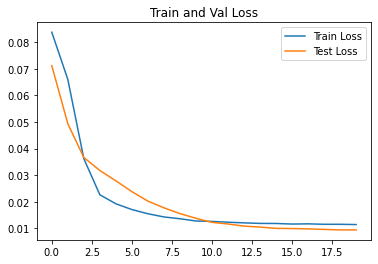

In [17]:
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epoch)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

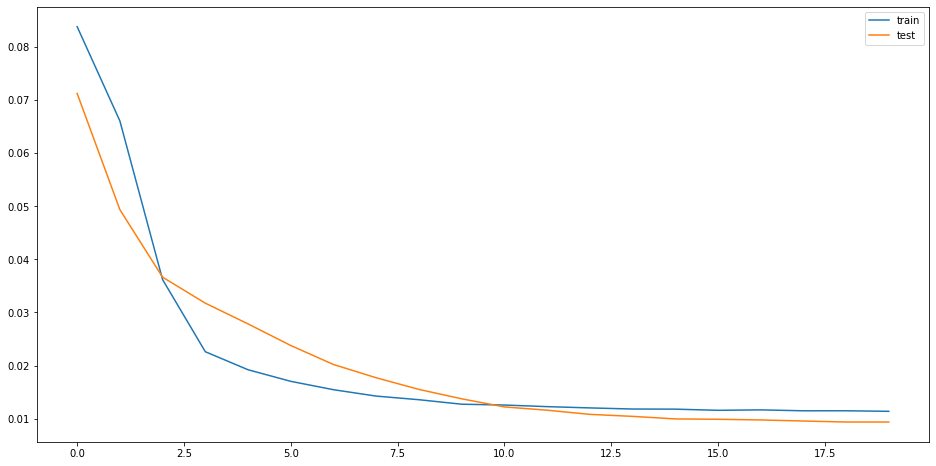

303/303 [==============================] - 1s 1ms/step


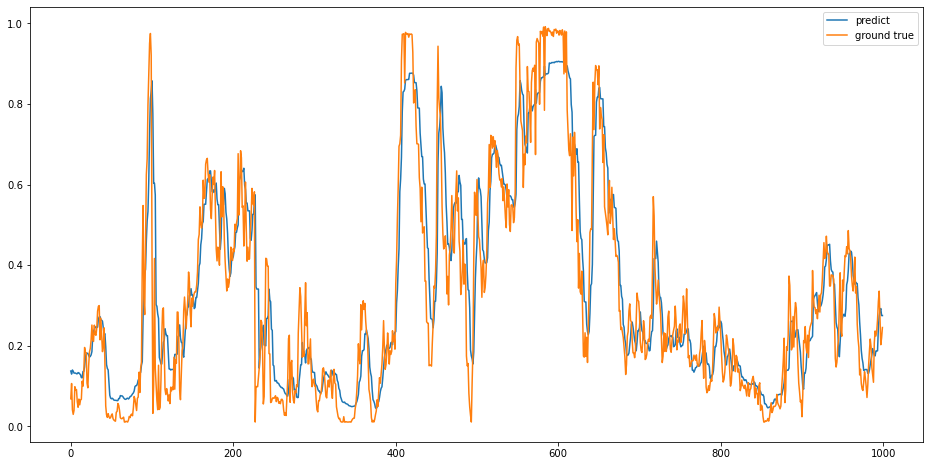

In [18]:
plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
plt.figure(figsize=(16, 8))
predict = model.predict(x_test)
plt.plot(predict[:1000], label='predict')
plt.plot(y_test[:1000], label='ground true')
plt.legend()
plt.show()

303/303 [==============================] - 0s 1ms/step


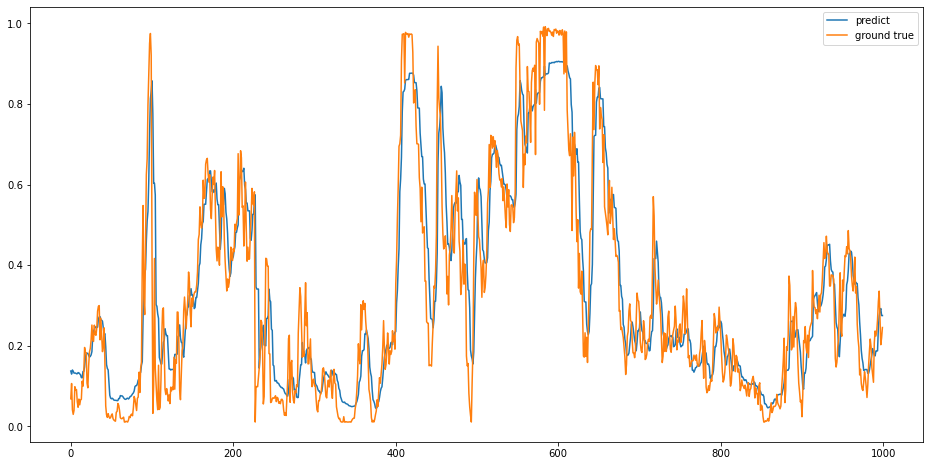

In [19]:
plt.figure(figsize=(16, 8))
predict = model.predict(x_test)
plt.plot(predict[:1000], label='predict')
plt.plot(y_test[:1000], label='ground true')
plt.legend()
plt.show()

303/303 [==============================] - 0s 1ms/step


Text(0.5, 1.0, 'Test Data')

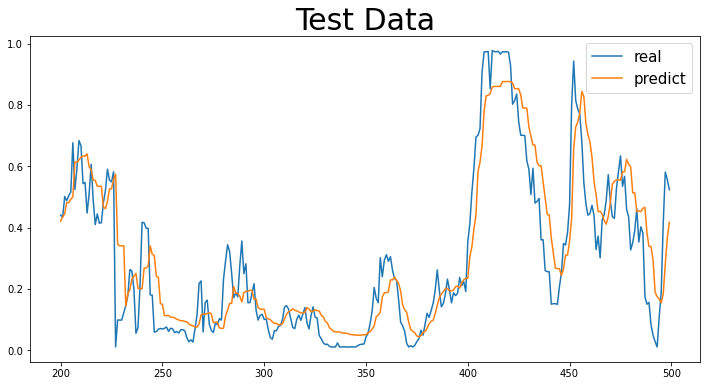

In [20]:
#在测试集上的预测
y_test_predict=model.predict(X_test)
y_test_predict=y_test_predict[:,0]
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1);
draw.iloc[200:500,0].plot(figsize=(12,6))
draw.iloc[200:500,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题

In [21]:
def acc(p_pre,p_test):
    V = 96.4
    TotalE = 0
    times = 1
    for z in range(times):
        E = 0
        for m in range(96):
            E = E + (p_pre[z * 96 + m] - p_test[z * 96 + m]) ** 2
        P = 1 - ((E / (V * V)) / 96) ** 0.5
        TotalE = TotalE + P
    return(TotalE/times)

In [22]:
#准确率计算
acc(predict,y_test)

array([0.9992205], dtype=float32)

下方单元格中文件路径同样要修改

In [23]:

#保存数据用
data_save = df
data_save.loc[:, '时间'] = df_data_save0['时间']
data_save.drop(data_save.index[int(row):int(row) + window],inplace=True)
data_save.drop(data_save.index[0:window],inplace=True)
data_save = data_save.reset_index(drop=True)

#存入数据
predict1 = model.predict(X_train)
predict2 = model.predict(x_test)
predict1 = pd.DataFrame(predict1)
predict2 = pd.DataFrame(predict2)
predict = pd.concat([predict1,predict2],ignore_index = True)
data = {'时间':data_save["时间"]}
data = pd.DataFrame(data)
data.loc[:, "实际功率"] = data_save["实际功率"]
data.loc[:, "预测功率"] = predict


#此处文件路径同样要修改
xlsPath = "..//风电场预测功率.xlsx"


writer = pd.ExcelWriter(xlsPath)
data.to_excel(writer, sheet_name="预测功率结果")
writer.save()

303/303 [==============================] - 0s 1ms/step


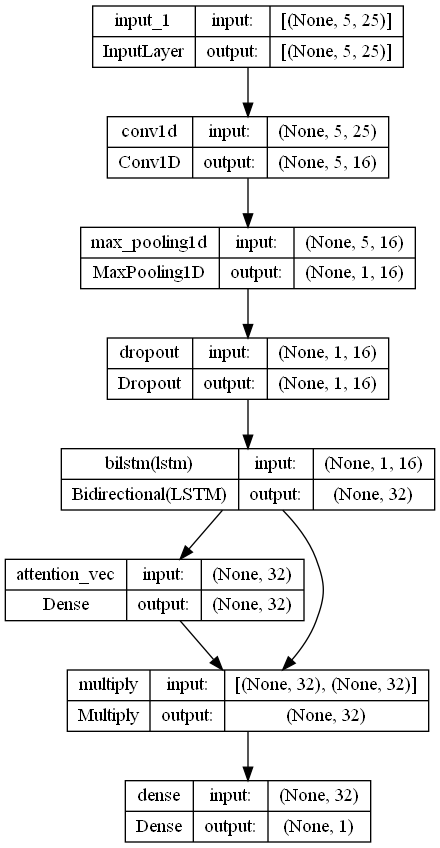

In [24]:
from keras.utils import plot_model
plot_model(model, to_file="model.png",show_shapes=True)

In [25]:
model.save('注意力机制model')
new_model = tf.keras.models.load_model('注意力机制model')

INFO:tensorflow:Assets written to: 注意力机制model\assets


INFO:tensorflow:Assets written to: 注意力机制model\assets
